<a href="https://colab.research.google.com/github/myutman/DUL/blob/HW3/HW3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.functional import F

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pickle

device = torch.device('cuda:0')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
        )

    def forward(self, x):
        return self.seq(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 6, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        return self.seq(x)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.normal = torch.distributions.normal.Normal(0, 1)

    def encode(self, x):
        t = self.encoder(x)
        mu = t[:,:256,:,:]
        sigma = t[:,256:,:,:,].exp()
        return mu, sigma

    def decode(self, z):
        t = self.decoder(z)
        mu = t[:,:3,:,:]
        sigma = t[:,3:,:,:].exp()
        return mu, sigma

    def reparametrize(self, mu, sigma):
        if self.training:
            z = self.normal.sample(mu.shape).to(device)
            n1 = z * sigma
            return mu + n1
        else:
            return mu

    def forward(self, x):
        mu1, sigma1 = self.encode(x)
        z = self.reparametrize(mu1, sigma1)
        mu2, sigma2 = self.decode(z)
        return mu1, sigma1, mu2, sigma2

def KL(mu, sigma):
    return torch.mean(((sigma + mu**2 - np.prod(mu.shape[-3:]) - torch.log(sigma + 1e-9)) / 2).sum(dim=(-1, -2, -3)))

def CrossEntropy(mu, sigma, x):
    return torch.mean(((torch.log(sigma + 1e-9) + np.log(2 * np.pi) + ((x - mu)**2 * sigma**(-1))) / 2).sum(dim=(-1, -2, -3)))

class ELBOLoss(nn.Module):
    def __init__(self):
        super(ELBOLoss, self).__init__()
    
    def forward(self, input, mu_e, sigma_e, mu_d, sigma_d):
        self.kl = KL(mu_e, sigma_e)
        self.ce = CrossEntropy(mu_d, sigma_d, input)
        return self.kl + self.ce

In [0]:
def train(model, train, test, loss_function, n_epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss = []
    test_loss = []
    train_kl = []
    test_kl = []
    train_ce = []
    test_ce = []
    for i in tqdm(range(n_epochs)):
        model.train()
        train_losses = []
        train_kls = []
        train_ces = []
        for batch in tqdm(train):
            optimizer.zero_grad()
            mu_e, sigma_e, mu_d, sigma_d = model(batch.float().to(device))
            #print(mu_e.shape, sigma_e.shape, mu_d.shape, sigma_d.shape)
            loss = loss_function(batch.float().to(device), mu_e, sigma_e, mu_d, sigma_d)
            train_losses.append(float(loss.cpu().float()))

            kl = loss_function.kl.cpu()
            ce = loss_function.ce.cpu()
            train_kls.append(float(kl.float()))
            train_ces.append(float(ce.float()))
            loss.backward()
            optimizer.step()
        if (np.isnan(np.mean(train_losses))):
            print(train_losses)
        train_loss.append(np.mean(train_losses))
        train_kl.append(np.mean(train_kls))
        train_ce.append(np.mean(train_ces))

        with torch.no_grad():
            model.eval()
            test_losses = []
            test_kls = []
            test_ces = []
            for batch in test:
                mu_e, sigma_e, mu_d, sigma_d = model(batch.float().to(device))
                loss = loss_function(batch.float().to(device), mu_e, sigma_e, mu_d, sigma_d)
                test_losses.append(float(loss.cpu().float()))

                kl = loss_function.kl.cpu()
                ce = loss_function.ce.cpu()
                
                test_kls.append(float(kl.float()))
                test_ces.append(float(ce.float()))
            test_loss.append(np.mean(test_losses))
            test_kl.append(np.mean(test_kls))
            test_ce.append(np.mean(test_ces))

    return train_loss, test_loss, train_kl, test_kl, train_ce, test_ce

In [0]:
dataset = []
with open('/content/drive/My Drive/DUL/hw3-q2.pkl', 'rb') as file:
    dataset = pickle.load(file)

In [40]:
train_data = dataset['train'].transpose(0, 3, 1, 2) / 128. - 1
test_data = dataset['test'].transpose(0, 3, 1, 2) / 128. - 1

train_batches = data.DataLoader(train_data, batch_size=32)
test_batches = data.DataLoader(test_data, batch_size=32)

model1 = VAE()
model1.to(device)

elboloss = ELBOLoss()
elboloss.to(device)

num_epochs = 10
train_losses1, test_losses1, train_kl1, test_kl1, train_ce1, test_ce1 = train(model1, train_batches, test_batches, elboloss, num_epochs, 5e-5)

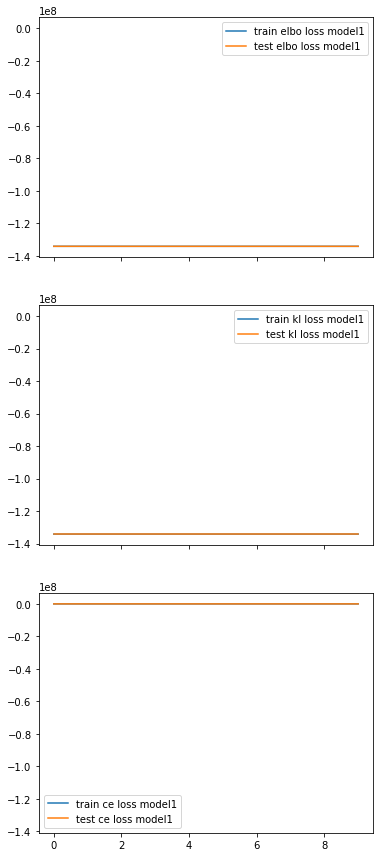

In [42]:
fig = plt.figure(figsize=(6, 15))
ax = fig.subplots(nrows=3, ncols=1, sharex=True, sharey=True)
ax[0].plot(range(num_epochs), train_losses1)
ax[0].plot(range(num_epochs), test_losses1)
ax[0].legend(['train elbo loss model1', 'test elbo loss model1'])

ax[1].plot(range(num_epochs), train_kl1)
ax[1].plot(range(num_epochs), test_kl1)
ax[1].legend(['train kl loss model1', 'test kl loss model1'])

ax[2].plot(range(num_epochs), train_ce1)
ax[2].plot(range(num_epochs), test_ce1)
ax[2].legend(['train ce loss model1', 'test ce loss model1'])

plt.show()

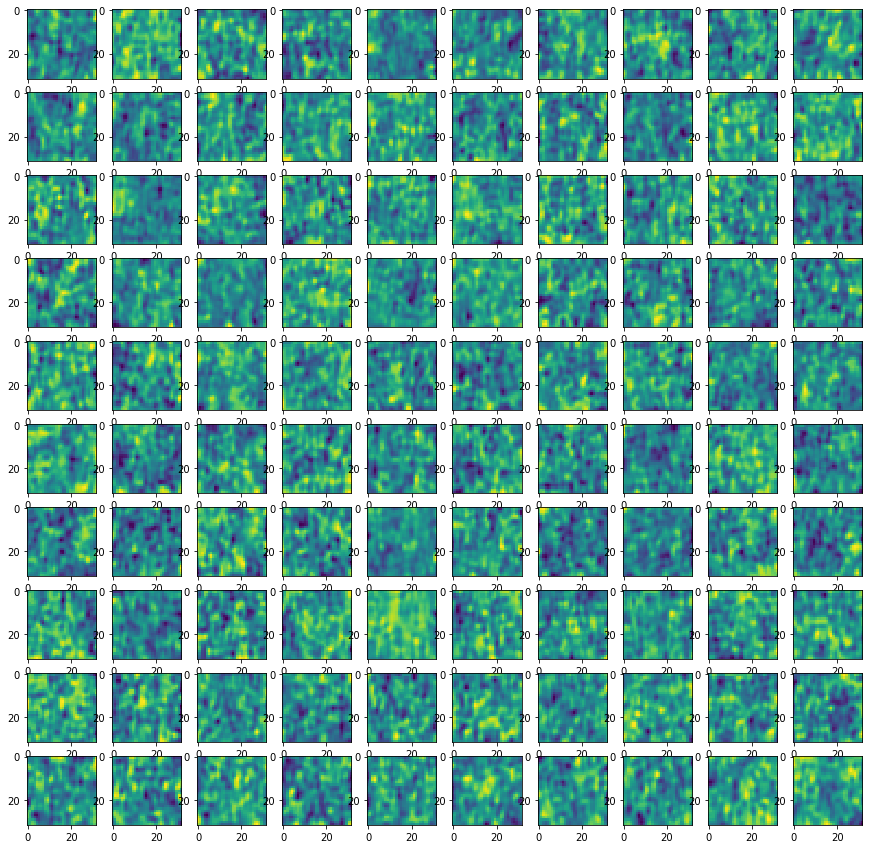

In [57]:
fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(nrows=10, ncols=10)

mu, sigma = model1.decode(model1.normal.sample((100, 256, 8, 8)).to(device))
mu = mu.cpu().detach().numpy()
#mu = train_data

for i in range(10):
    for j in range(10):    
        ax[i][j].imshow(mu[i * 10 + j].mean(axis=-3))
        #print(mu[i * 10 + j].mean(axis=-1).shape)

plt.show()